# Part 2 - Generalized Linear Model

**TODO** Introduction - worum gehts hier


## Loading some spike data

We load spike data from a file and -- first of all -- reduce their temporal resolution so that later computations are a bit less slow. Read the code if you find that interesting, otherwise just execute the next cell :)

In [ ]:
from matplotlib.pyplot import *
%matplotlib inline
import numpy as np

def reduce_resolution(array,factor,sum_spikes=True):
    """ 
    Reduces the temporal resolution of an array of spike trains.
    
    This can cause multiple spikes to fall into one time bin, i.e. the
    returned array can contain integers > 1.
    If sum_spikes is set to False, we do not sum spike counts. Instead,
    any spike counts > 1 in one bin are truncated down to 1. In that case,
    a binary array is returned, but some spikes may be lost.
    
    Arguments:
        array: 4D numpy array. Reduction will occur along the last dimension (T).
        factor: integer to divide the number of time bins by.
        sum_spikes: If false, truncate the number of spikes per bin to 1.
      
    Returns:
        4D numpy array, similar as input but last dimension with length T/factor.
    """
    assert type(factor) is int
    reduced_shape = (array.shape[0],array.shape[1],array.shape[2],array.shape[3]/np.round(factor))
    spikes_reduced = np.zeros(reduced_shape) # create a shortened result array
    for idx in np.ndindex(array.shape[0:3]): # for all indices along the first 3 dimensions..
        spiketimes = (array[idx].nonzero()[0] / factor).astype(int) # get spiketimes, divide by factor
        for spiketime in spiketimes: # loop manually, since numpy indexing treats index lists as sets
            spikes_reduced[idx[0],idx[1],idx[2],spiketime] += 1 # increment result array by 1 at the divided spiketimes
    
    if not sum_spikes:
        spikes_reduced  = spikes_reduced >= 1
    spikecount_difference = (np.sum(array) - np.sum(spikes_reduced)).astype(int)
    if spikecount_difference > 0:
        print "Lost "+str(spikecount_difference)+" spikes through resolution reduction."
    return spikes_reduced    


# Load the data:
with np.load('data.npz') as archive:
    original_spikes = archive['spikes_outputencoding']

# reduce resolution:
max_spikes_per_bin = 10 # <-- resolution reduction factor
spikes = reduce_resolution(original_spikes,factor=max_spikes_per_bin, sum_spikes=True)

# choose a subset of the data (one cell & one experimental condition):
cell = 1
condition = 1
N = spikes.shape[2] # number of trials
T = spikes.shape[3] # length of a trial
all_spiketrains = spikes[cell,condition,:,:] # N x T array containing only the subset of data that we picked


# Plot an example spike train:
figure(figsize=(13,1))
trial = 2
plot(spikes[cell,condition,trial,:],'k')
title('spike data from cell '+str(cell)+', condition '+str(condition)+', trial '+str(trial))
up = ylim()[1]
ylim(0,up+0.1)
yticks([])
xlim([0,T])
xlabel('step')

## Filtering

**todo intro / motivation for filtering.**

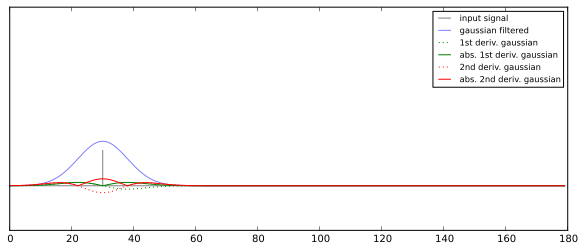

In [180]:
from scipy.ndimage.filters import gaussian_filter1d

sigma = 8 # see what happens if you change this.

def plot_filtered(y):
    x = np.arange(180)
    figure(figsize=(10,4))
    plot(x,np.zeros(x.shape),'k',alpha=0.5,label='input signal')
    vlines(np.argwhere(y),0,0.04,'k',alpha=0.5)
    plot(x,gaussian_filter1d(y, sigma=sigma, order=0), "b",label='gaussian filtered',alpha=0.5)
    plot(x,gaussian_filter1d(y, sigma=sigma, order=1), "g:",label='1st deriv. gaussian')
    plot(x,np.abs(gaussian_filter1d(y, sigma=sigma, order=1)), "g",label='abs. 1st deriv. gaussian')    
    plot(x,gaussian_filter1d(y, sigma=sigma, order=2)*10, ":r",label='2nd deriv. gaussian')
    plot(x,np.abs(gaussian_filter1d(y, sigma=sigma, order=2)*10), "r",label='abs. 2nd deriv. gaussian')    
    legend(fontsize='small')
    ylim([-0.05,0.2])
    yticks([])


y = np.zeros(x.shape)
y[30] = 1
plot_filtered(y)


We now filter a short sequence of spikes. You can observe three things:

* filtering the sequence with a Gaussian filter is like a firing rate estimate (the more dense the spikes, the higher the value)
* filtering with the first derivative of a Gaussian yields the rate of change of that estimate
* filtering with the 2nd derivative of a Gaussian yields its *curvature*

In essence, the derivatives tell us at each point in time ** how the spike rate is currenly changing.**

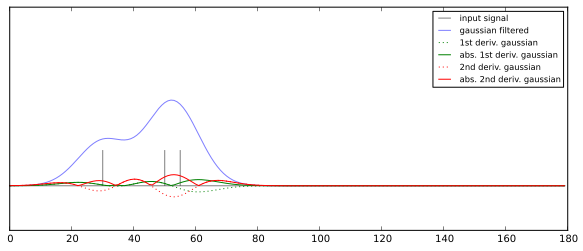

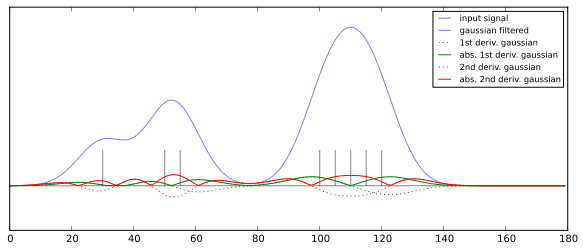

In [179]:
y = np.zeros(x.shape)
y[[30,50,55]] = 1
plot_filtered(y)

y = np.zeros(x.shape)
y[[30,50,55,100,105,110,115,120]] = 1
plot_filtered(y)

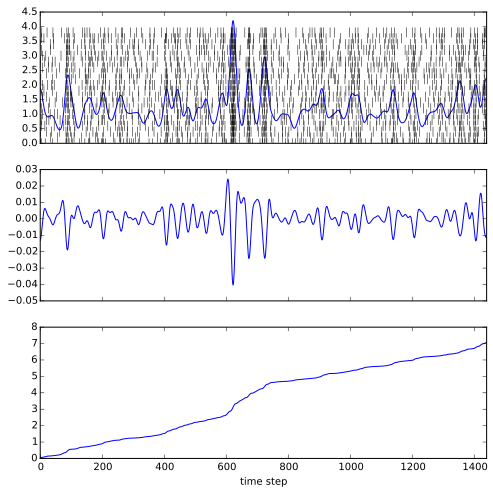

In [128]:
order = 2


spiketrain_gauss    = gaussian_filter1d(all_spiketrains.sum(axis=0), sigma=sigma, order=0)
spiketrain_gauss_d2 = gaussian_filter1d(all_spiketrains.sum(axis=0), sigma=sigma, order=order)

def calc_cum_curv(y, sigma=10):
    """ Calculates the curvature of the smoothed vector `y`"""
    return np.cumsum(abs(gaussian_filter1d(y, sigma=sigma, order=order)))

cumulative_curvature = calc_cum_curv(all_spiketrains.sum(axis=0), sigma=sigma)

spike_y,spike_t = np.where(all_spiketrains)

figure(figsize=(8,8))
ax1=subplot(3,1,1)
plot(spiketrain_gauss)
plot(spike_t,spike_y*4.0/N,"k|", alpha=0.4,ms=10)

ax2=subplot(3,1,2, sharex=ax1)
plot(spiketrain_gauss_d2)

ax3=subplot(3,1,3, sharex=ax1)
plot(cumulative_curvature)
xlim([0,T])
xlabel('time step')

for label in ax1.get_xticklabels() + ax2.get_xticklabels():
    label.set_visible(False) 

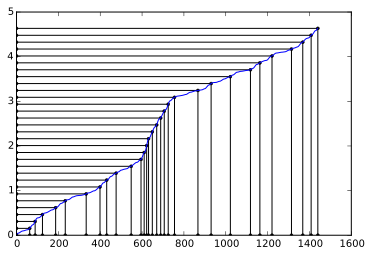

In [5]:
def find_percentiles(y, num_percentiles, return_thresholds=False):
    """ Finds `num_percentiles` equally spaced percentiles of `y` (a monotonically increasing vector),
    i.e. it approximates the inverse `x` of the function `y=f(x)` 
    at `num_percentiles` equally spaced `y`-values between 0 and `y[-1]`.
    
    Arguments:
        y:                  a sequence of monotonically increasing function values
        num_percentiles:    number of percentiles to find between 0 and `y[-1]`.
        return_threshold:   boolean value to indicated whether or not to return the thresholds, too
    Returns:
        percentiles:        `y`-values of the percentiles
        [thresholds:        `x`-values of the percentiles]
    """
    thresholds = np.linspace(0,y[-1],num_percentiles+1)
    percentiles = np.zeros_like(thresholds)
    
    current = 1
    for step in range(T):
        if y[step] > thresholds[current]:
            percentiles[current] = step
            current +=1
    
    percentiles[-1] = len(y)
    if return_thresholds:
        return percentiles, thresholds
    else:
        return percentiles

    
num_knots = 30
adaptive_rate_knots, percentiles = find_percentiles(cumulative_curvature, num_knots, return_thresholds=True)


figure()
for px,py in zip(adaptive_rate_knots, percentiles):
    plot([0,px,px],[py,py,0],'k.-')
    
plot(cumulative_curvature)

## Excercise 1

** TODO ** text.

30
-2180.93025201


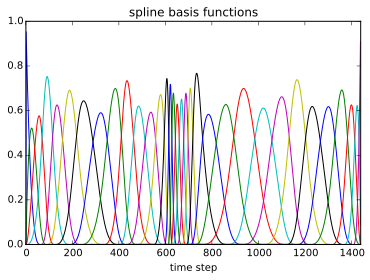

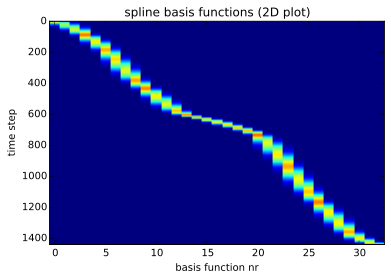

In [6]:
import statsmodels.api as sm
import splines


# spline_order = ...
# knots = ...
# spline_bases = ...
# dm = ...

# model = sm.GLM(...)
# fitted_model = model.fit()
# prediction = fitted_model.predict(...)
print num_knots

spikes_across_trials = all_spiketrains.sum(axis=0, keepdims=True).T

spikes_nospikes = np.hstack([spikes_across_trials, N*max_spikes_per_bin-spikes_across_trials])

spline_order = 3                                                      # solution
knots = splines.augknt(adaptive_rate_knots, spline_order)
#-> LL of -2126.64427217
#knots        = splines.augknt(np.linspace(0,T,num_knots),spline_order)       # solution
#-> LL of -2172.54553485
spline_bases = np.array(splines.spcol(range(T),knots,spline_order))   # solution

model = sm.GLM(spikes_nospikes,spline_bases,family=sm.families.Binomial())      # solution
fitted_model = model.fit()                                            # solution
prediction = fitted_model.predict(spline_bases)                       # solution



figure()
plot(spline_bases)
xlim([0,T])
title('spline basis functions')
xlabel('time step')

figure()
imshow(spline_bases,aspect='auto',interpolation='nearest')
title('spline basis functions (2D plot)')
ylabel('time step')
xlabel('basis function nr')

print fitted_model.llf

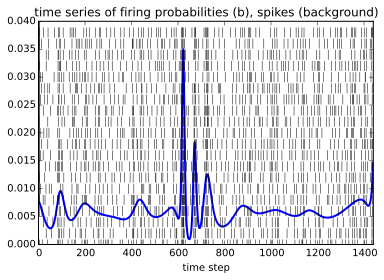

In [7]:
ylims   = (0,0.04)

figure()
plot(prediction,linewidth=2)
plot(spike_t,spike_y*ylims[1]/N,"k|", alpha=0.4,ms=10)
ylim(ylims)
xlim([0,T])
title('time series of firing probabilities (b), spikes (background)')
xlabel('time step')

## Exercise 2

Number of knots: 50, knots type: adaptive spacing, AIC: 4364.97
Number of knots: 50, knots type: linear spacing, AIC: 4449.09
Number of knots: 60, knots type: adaptive spacing, AIC: 4322.03
Number of knots: 60, knots type: linear spacing, AIC: 4470.13
Number of knots: 70, knots type: adaptive spacing, AIC: 4278.68
Number of knots: 70, knots type: linear spacing, AIC: 4319.84
Number of knots: 80, knots type: adaptive spacing, AIC: 4282.4
Number of knots: 80, knots type: linear spacing, AIC: 4299.81
Number of knots: 90, knots type: adaptive spacing, AIC: 4274.46
Number of knots: 90, knots type: linear spacing, AIC: 4309.66
Number of knots: 100, knots type: adaptive spacing, AIC: 4250.93
Number of knots: 100, knots type: linear spacing, AIC: 4280.03
Number of knots: 110, knots type: adaptive spacing, AIC: 4262.59
Number of knots: 110, knots type: linear spacing, AIC: 4265.91
Number of knots: 120, knots type: adaptive spacing, AIC: 4265.19
Number of knots: 120, knots type: linear spacing, 

NameError: name 'best_prediction' is not defined

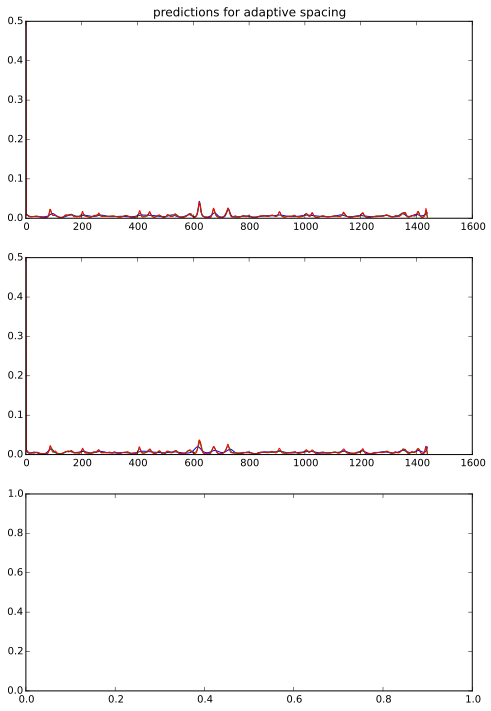

In [8]:
#def ll(ps,xs):
#    ...

import scipy as sp

def ll(ps, xs, max_spikes=1):                                                                 # solution
    return sum(np.log(sp.special.binom(max_spikes, xs)) + xs*np.log(ps) +(max_spikes - xs) * np.log(1-ps))                         # solution

num_knots_candidates = [50,60,70,80,90,100,110,120,130,140,150]
num_knots_plot       = [50,100,150]

best_loglikelihood = -np.inf
best_num_knots     = None

training_spikes     = all_spiketrains.sum(axis=0, keepdims=True).T

AIC = np.zeros((len(num_knots_candidates),2))
figure(figsize=(8,12))
ax = [subplot(3,1,1), subplot(3,1,2), subplot(3,1,3)]


best_AIC = np.inf
for i,num_knots in enumerate(num_knots_candidates):
    for knots_type in range(2):    
        if knots_type == 0:
            percentiles = find_percentiles(calc_cum_curv(training_spikes,sigma=sigma), num_knots)
            rate_knots  = splines.augknt(percentiles, spline_order)
        else:
            rate_knots  = splines.augknt(np.linspace(0,T,num_knots), spline_order)
            
        spline_bases        = np.array(splines.spcol(range(T),rate_knots,spline_order))          # solution
        spikes_nospikes     = np.hstack([training_spikes, N*max_spikes_per_bin-training_spikes])
        model               = sm.GLM(spikes_nospikes,spline_bases,family=sm.families.Binomial())# solution
        fitted_model        = model.fit()    
        AIC[i,knots_type]   = fitted_model.aic
        if fitted_model.aic < best_AIC:
            best_AIC        = fitted_model.aic
            best_num_knots  = num_knots
            best_knots_type = knots_type   
        
        if num_knots in num_knots_plot:
            ax[knots_type].plot(fitted_model.predict(spline_bases))
        
        print "Number of knots: %d, knots type: %s, AIC: %g" % (num_knots, "linear spacing" if knots_type==1 else "adaptive spacing",fitted_model.aic)

print "\nThe best AIC-score of %g was found for %d knots (%s)." % (best_AIC, best_num_knots, "linear spacing" if best_knots_type==1 else "adaptive spacing")

for i in range(2):
    ax[i].set_title("predictions for " + ["adaptive spacing", "linear spacing"][i])
    ax[i].plot(best_prediction)
    ax[i].legend(map(lambda n: "%d knots" % n, num_knots_plot))
    ax[i].plot(spike_t, spike_y/20.0*0.04, "k|", alpha=0.4, ms=10)
    ax[i].set_ylim([0,0.04])
    ax[i].set_xlim([0,T])
    ax[i].set_ylabel("prediction / spikes")
ax[1].set_xlabel("time steps")

ax[2].plot(num_knots_candidates, AIC)
ax[2].legend(["adaptive spacing", "linear spacing"])
ax[2].set_title("AIC scores vs. number of knots")
ax[2].set_xlabel("number of knots")
ax[2].set_ylabel("AIC score")